In [1]:
import pandas as pd
import os
import numpy as np
from itertools import combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

In [2]:
os.listdir("mba")

['Association_customer-recommendations.docx', 'Dataset.xlsx']

In [3]:
data = pd.read_excel("mba/Dataset.xlsx", header=None)

In [4]:
data.shape

(7501, 20)

In [6]:
data.head()

0          1           2                 3             4   \
0         shrimp    almonds     avocado    vegetables mix  green grapes   
1        burgers  meatballs        eggs               NaN           NaN   
2        chutney        NaN         NaN               NaN           NaN   
3         turkey    avocado         NaN               NaN           NaN   
4  mineral water       milk  energy bar  whole wheat rice     green tea   

                 5     6               7             8             9   \
0  whole weat flour  yams  cottage cheese  energy drink  tomato juice   
1               NaN   NaN             NaN           NaN           NaN   
2               NaN   NaN             NaN           NaN           NaN   
3               NaN   NaN             NaN           NaN           NaN   
4               NaN   NaN             NaN           NaN           NaN   

               10         11     12     13             14      15  \
0  low fat yogurt  green tea  honey  salad  mineral water  salmon   
1             NaN        NaN    NaN    NaN            NaN     NaN   
2             NaN        NaN    NaN    NaN            NaN     NaN   
3             NaN        NaN    NaN    NaN            NaN     NaN   
4             NaN        NaN    NaN    NaN            NaN     NaN   

                  16               17       18         19  
0  antioxydant juice  frozen smoothie  spinach  olive oil  
1                NaN              NaN      NaN        NaN  
2                NaN              NaN      NaN        NaN  
3                NaN              NaN      NaN        NaN  
4                NaN              NaN      NaN        NaN

In [7]:
all_items = []
for col in data.columns:
    all_items.extend(data[col].dropna().values)

In [8]:
all_items_text = " ".join([x.replace(" ", "_") for x in all_items])
word_cloud = WordCloud(width = 800, height = 800, collocations = False, background_color = 'white').generate(all_items_text)

In [9]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
 
plt.show()

In [10]:
len(set(all_items))

119

## Data Preprocessing

In [11]:
orignial_count = [data.iloc[x, :].dropna().shape[0] for x in range(data.shape[0])]
unique_count = [data.iloc[x, :].dropna().unique().shape[0] for x in range(data.shape[0])]

In [12]:
orignial_count1 = pd.Series(orignial_count)
unique_count1 = pd.Series(unique_count)

In [16]:
duplicates = orignial_count1.compare(unique_count1)
duplicates.columns =['Original', "Processed"]
duplicates

Original  Processed
4394       8.0        7.0
4494       6.0        5.0
4526       6.0        5.0
6903       8.0        7.0
7109       8.0        7.0

##### We can see that transaction number 4394, 4494, 4526, 6903 and 7109 are having duplicate items in the transaction, lets print on of these transactions to verify the same

In [15]:
data.iloc[4394, :].dropna()

0             burgers
1                 ham
2                eggs
3    whole wheat rice
4                 ham
5        french fries
6             cookies
7           green tea
Name: 4394, dtype: object

##### Yes as we suspected there are duplicate items in the transactions, lets remove these in order to avoid further problems in forming frequent itemsets

##### ham is repeating twice

#### Let us remove these duplicate items from the transactions.

In [17]:
for val in duplicates.index.values:
    data.iloc[val, :] = pd.Series(data.iloc[val, :].unique()).reindex(range(20))

In [18]:
data.iloc[4394, :].dropna()

0             burgers
1                 ham
2                eggs
3    whole wheat rice
4        french fries
5             cookies
6           green tea
Name: 4394, dtype: object

#### Yes we have successfully eliminated the duplicates
<b>Note:</b> I think its also a good idea to remove the transactions having just 1 item, but our dataset is smaller so its okay to leave them as is for now.

#### Generatin One-hot encoding dataset from the items data

- Get unique items
- Create a dictionary with item and the index number
- Above details will help us to generate one-hot-encoding 

In [19]:
all_items = set(all_items)

In [20]:
item_dict = dict(zip(all_items, range(119)))

In [21]:
one_hot_en = []
for i, r in data.iterrows():
    row = [0]*119
    for x in r:
        if x is not np.nan:
            row[item_dict[x]] = 1
    one_hot_en.append(row)

In [22]:
df = pd.DataFrame(one_hot_en, columns=all_items)

In [23]:
df.head()

green tea  chutney  burger sauce  mint green tea  corn  rice  cereals  \
0          1        0             0               0     0     0        0   
1          0        0             0               0     0     0        0   
2          0        1             0               0     0     0        0   
3          0        0             0               0     0     0        0   
4          1        0             0               0     0     0        0   

   sparkling water  pancakes  sandwich  ...  grated cheese  \
0                0         0         0  ...              0   
1                0         0         0  ...              0   
2                0         0         0  ...              0   
3                0         0         0  ...              0   
4                0         0         0  ...              0   

   clothes accessories  ketchup  hand protein bar  cooking oil  yams  \
0                    0        0                 0            0     1   
1                    0        0                 0            0     0   
2                    0        0                 0            0     0   
3                    0        0                 0            0     0   
4                    0        0                 0            0     0   

   protein bar  oatmeal  soup  bug spray  
0            0        0     0          0  
1            0        0     0          0  
2            0        0     0          0  
3            0        0     0          0  
4            0        0     0          0  

[5 rows x 119 columns]

##### Initial assumptions for the support and confidence threshold, will observe the results and update these parameters accordingly, if required

In [25]:
N = df.shape[0]
min_support = 1  ### 1%
min_confidence = 35  ### 35%

###### Formula for calculating support

![support](support.png)

###### Formula for calculating confidence

![confidence](confidence.png)

##### Okay, now that we are ready with our dataset, let's try to generate frequest 1-itemsets. 

In [26]:
c1 = df.sum()
l1 = (c1/ N) * 100
l1 = l1[l1 >= min_support]

In [27]:
l1.shape

(75,)

###### So number of frequest 1-itemsets are 75

##### Wow, that's great, based on our transactional data, we found that 75 items are being purchased frequently, which qualify our support threshold

##### Now let's use this information to generate 2-itemsets

In [28]:
k2_items = list(combinations(list(l1.index), 2))

In [29]:
len(k2_items)

2775

In [30]:
counts = []
for item in k2_items:
    counts.append((df[item[0]]*df[item[1]]).sum())

In [31]:
c2 = pd.DataFrame()
c2['itemset'] = k2_items
c2['counts'] = counts
c2['support'] = (c2.counts/N) * 100

##### Let us now calculate the confidence, below is the approach I am using to calculate the confidence

- Consider we have items set {I1, I2}
- Calculate confidence as c1 = {I1, I2} / I1
- Calculate confidence as c2 = {I2, I1} / I2
- Get the maximum of (c1, c2), and that's our confidence score

This is just a manual approach, further will use some library to calculate all these stuff and compare the results

In [32]:
c2['confidence (x -> y)'] = [((r['counts'] / c1[r['itemset'][0]]) * 100) for i, r in c2.iterrows()]
c2['confidence (y -> x)'] = [((r['counts'] / c1[r['itemset'][1]]) * 100) for i, r in c2.iterrows()]
c2['max_confidence'] = c2[['confidence (x -> y)', 'confidence (y -> x)']].max(axis=1)

In [33]:
c2[(c2['support'] >= min_support) & (c2['max_confidence'] >= min_confidence)]

itemset  counts   support  \
199             (cereals, mineral water)      77  1.026530   
270            (pancakes, mineral water)     253  3.372884   
340           (olive oil, mineral water)     207  2.759632   
1424            (ground beef, spaghetti)     294  3.919477   
1429        (ground beef, mineral water)     307  4.092788   
1574               (red wine, spaghetti)      77  1.026530   
1579           (red wine, mineral water)      82  1.093188   
1809             (salmon, mineral water)     128  1.706439   
2320           (tomatoes, mineral water)     183  2.439675   
2502  (frozen vegetables, mineral water)     268  3.572857   
2585            (mineral water, chicken)     171  2.279696   
2586               (mineral water, milk)     360  4.799360   
2600        (mineral water, cooking oil)     151  2.013065   
2603               (mineral water, soup)     173  2.306359   

      confidence (x -> y)  confidence (y -> x)  max_confidence  
199             39.896373             4.306488       39.896373  
270             35.483871            14.149888       35.483871  
340             41.902834            11.577181       41.902834  
1424            39.891452            22.511485       39.891452  
1429            41.655360            17.170022       41.655360  
1574            36.492891             5.895865       36.492891  
1579            38.862559             4.586130       38.862559  
1809            40.125392             7.158837       40.125392  
2320            35.672515            10.234899       35.672515  
2502            37.482517            14.988814       37.482517  
2585             9.563758            38.000000       38.000000  
2586            20.134228            37.037037       37.037037  
2600             8.445190            39.425587       39.425587  
2603             9.675615            45.646438       45.646438

#### Awesome, we found 14 strong frequest itemsets
Rules that satisfy both minimum-support threshold and minimun-confidence threshold are call <b>Strong</b>

In [34]:
l2 = c2[c2['support'] >= min_support]
l2_unique_items = list((set([x[0] for x in l2['itemset']] + [x[1] for x in l2['itemset']])))

In [35]:
l2.shape

(165, 6)

###### Number of frequest 2-itemsets are 165
##### Now let's use this information to generate 3-itemsets

In [36]:
k3_items = list(combinations(list(l2_unique_items), 3))
print(len(k3_items))

5456


In [37]:
counts3 = []
for item in k3_items:
    counts3.append((df[item[0]]*df[item[1]]*df[item[2]]).sum())

In [38]:
c3 = pd.DataFrame()
c3['itemset'] = k3_items
c3['counts'] = counts3
c3['support'] = (c3.counts/N) * 100

In [39]:
def find_itemset(itemset):
    for i, r in l2.iterrows():
        if len(set(itemset) - set(r['itemset'])) == 0:
            return r['counts']
        else:
            return 0
        break

##### Same approach is being used for confidence calculation for 3-itemset

In [40]:
xyz_conf = []
yzx_conf = []
zxy_conf = []
for i, r in c3.iterrows():
    if find_itemset(r['itemset'][0:2]) == 0:
        xyz_conf.append(0)
    else:
        xyz_conf.append((r['counts']/find_itemset(r['itemset'][0:2]))*100)
    
    if find_itemset(r['itemset'][1:]) == 0:
        yzx_conf.append(0)
    else:
        yzx_conf.append((r['counts']/find_itemset(r['itemset'][1:]))*100)
        
    if find_itemset(r['itemset'][::2]) == 0:
        zxy_conf.append(0)
    else:
        zxy_conf.append((r['counts']/find_itemset(r['itemset'][::2]))*100)

In [41]:
c3['confidence xy->z'] = xyz_conf
c3['confidence yz->z'] = yzx_conf
c3['confidence zx->y'] = zxy_conf

In [42]:
c3['max_confidence'] = c3[['confidence xy->z','confidence yz->z','confidence zx->y']].max(axis=1)

In [43]:
c3[c3['support'] >= 1].shape

(17, 7)

###### Number of frequest 3-itemsets are 17

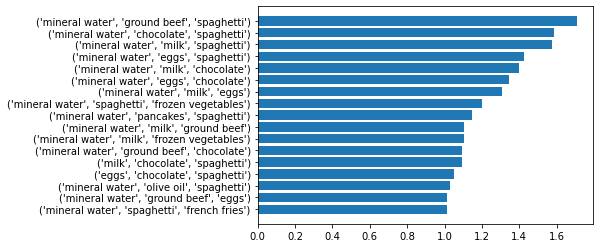

In [44]:
plt_data = c3[c3['support'] >= 1].sort_values('support')
plt_data['itemset'] = plt_data['itemset'].apply(str)
plt.barh(plt_data.itemset, plt_data.support)
plt.show()

##### Now that we calculated frequent itemsets by manual processing and calculations, we can try some libraries and do the same and compare both the results
### Let us use MLXtend library to generate and evaluate rules

In [45]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules

In [46]:
# filling null values with string "ZERO", later it will be easy for us to remove
dataset = data.fillna("ZERO")

In [47]:
# using TransactionEncoder to encode items data to True/False, its similar to one hot encoding
encoding = TransactionEncoder()
encoding.fit(dataset.values)
encoded_data = encoding.transform(dataset.values)

In [48]:
# converting transformed values to pandas DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoding.columns_)

In [49]:
# removing the ZERO column
encoded_df.drop('ZERO', axis=1, inplace=True)

In [50]:
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True, max_len=4)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [51]:
frequent_itemsets.groupby("length").count()

support  itemsets
length                   
1            75        75
2           165       165
3            17        17

### Great...!!!
##### Okay we can see in the above table that, when we generated frequest itemsets manually (without using any library), got same number of itemsets.

### Now let's try FP Growth algorithm with same parameters and compare the results

In [39]:
frequent_itemsets = fpgrowth(encoded_df, min_support=0.01, use_colnames=True, max_len=4)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [40]:
frequent_itemsets.groupby("length").count()

support  itemsets
length                   
1            75        75
2           165       165
3            17        17

###### FP Growth algorithm gives same results are Apriori. But main advantage of FP growth is, its faster and memory efficient

#### Now that we have generated frequent itemsets, let us produce association rules based on the same.

- Our metric to evaluate association rules is <b>Life</b> and the lift threshold is 1
- The lift metric is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1.


In [70]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [71]:
rules.shape

(406, 9)

In [72]:
rules

antecedents                         consequents  \
0                             (avocado)                     (mineral water)   
1                       (mineral water)                           (avocado)   
2                             (burgers)                              (cake)   
3                                (cake)                           (burgers)   
4                             (burgers)                         (chocolate)   
5                           (chocolate)                           (burgers)   
6                             (burgers)                              (eggs)   
7                                (eggs)                           (burgers)   
8                             (burgers)                      (french fries)   
9                        (french fries)                           (burgers)   
10                            (burgers)                 (frozen vegetables)   
11                  (frozen vegetables)                           (burgers)   
12                            (burgers)                         (green tea)   
13                          (green tea)                           (burgers)   
14                            (burgers)                       (ground beef)   
15                        (ground beef)                           (burgers)   
16                               (milk)                           (burgers)   
17                            (burgers)                              (milk)   
18                            (burgers)                     (mineral water)   
19                      (mineral water)                           (burgers)   
20                            (burgers)                          (pancakes)   
21                           (pancakes)                           (burgers)   
22                            (burgers)                         (spaghetti)   
23                          (spaghetti)                           (burgers)   
24                            (burgers)                            (turkey)   
25                             (turkey)                           (burgers)   
26                               (cake)                         (chocolate)   
27                          (chocolate)                              (cake)   
28                               (cake)                              (eggs)   
29                               (eggs)                              (cake)   
30                               (cake)                      (french fries)   
31                       (french fries)                              (cake)   
32                               (cake)                 (frozen vegetables)   
33                  (frozen vegetables)                              (cake)   
34                               (cake)                         (green tea)   
35                          (green tea)                              (cake)   
36                               (milk)                              (cake)   
37                               (cake)                              (milk)   
38                               (cake)                     (mineral water)   
39                      (mineral water)                              (cake)   
40                               (cake)                          (pancakes)   
41                           (pancakes)                              (cake)   
42                               (cake)                         (spaghetti)   
43                          (spaghetti)                              (cake)   
44                            (cereals)                     (mineral water)   
45                      (mineral water)                           (cereals)   
46                          (champagne)                         (chocolate)   
47                          (chocolate)                         (champagne)   
48                          (chocolate)                           (chicken)   
49                            (chicken)                         (chocolate)   

#### Ohh, we have 406 rules in total

##### We need to filter-out the relevent rules based on our min_support and min_confidence

In [73]:
rules[ (rules['confidence'] > 0.35) &
       (rules['support'] > 0.01) ].reset_index()

index                     antecedents      consequents  \
0      44                       (cereals)  (mineral water)   
1      59                       (chicken)  (mineral water)   
2     110                   (cooking oil)  (mineral water)   
3     182             (frozen vegetables)  (mineral water)   
4     218                   (ground beef)  (mineral water)   
5     227                   (ground beef)      (spaghetti)   
6     244                          (milk)  (mineral water)   
7     262                     (olive oil)  (mineral water)   
8     264                      (pancakes)  (mineral water)   
9     266                      (red wine)  (mineral water)   
10    269                        (salmon)  (mineral water)   
11    272                          (soup)  (mineral water)   
12    276                      (tomatoes)  (mineral water)   
13    291                      (red wine)      (spaghetti)   
14    306               (eggs, chocolate)  (mineral water)   
15    318        (ground beef, chocolate)  (mineral water)   
16    324               (milk, chocolate)  (mineral water)   
17    336          (spaghetti, chocolate)  (mineral water)   
18    342             (ground beef, eggs)  (mineral water)   
19    348                    (milk, eggs)  (mineral water)   
20    354               (spaghetti, eggs)  (mineral water)   
21    360       (spaghetti, french fries)  (mineral water)   
22    364       (milk, frozen vegetables)  (mineral water)   
23    370  (spaghetti, frozen vegetables)  (mineral water)   
24    376             (milk, ground beef)  (mineral water)   
25    382        (spaghetti, ground beef)  (mineral water)   
26    384    (ground beef, mineral water)      (spaghetti)   
27    388               (milk, spaghetti)  (mineral water)   
28    394          (spaghetti, olive oil)  (mineral water)   
29    396      (olive oil, mineral water)      (spaghetti)   
30    400           (spaghetti, pancakes)  (mineral water)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.025730            0.238368  0.010265    0.398964  1.673729   
1             0.059992            0.238368  0.022797    0.380000  1.594172   
2             0.051060            0.238368  0.020131    0.394256  1.653978   
3             0.095321            0.238368  0.035729    0.374825  1.572463   
4             0.098254            0.238368  0.040928    0.416554  1.747522   
5             0.098254            0.174110  0.039195    0.398915  2.291162   
6             0.129583            0.238368  0.047994    0.370370  1.553774   
7             0.065858            0.238368  0.027596    0.419028  1.757904   
8             0.095054            0.238368  0.033729    0.354839  1.488616   
9             0.028130            0.238368  0.010932    0.388626  1.630358   
10            0.042528            0.238368  0.017064    0.401254  1.683336   
11            0.050527            0.238368  0.023064    0.456464  1.914955   
12            0.068391            0.238368  0.024397    0.356725  1.496530   
13            0.028130            0.174110  0.010265    0.364929  2.095966   
14            0.033196            0.238368  0.013465    0.405622  1.701663   
15            0.023064            0.238368  0.010932    0.473988  1.988472   
16            0.032129            0.238368  0.013998    0.435685  1.827780   
17            0.039195            0.238368  0.015865    0.404762  1.698053   
18            0.019997            0.238368  0.010132    0.506667  2.125563   
19            0.030796            0.238368  0.013065    0.424242  1.779778   
20            0.036528            0.238368  0.014265    0.390511  1.638268   
21            0.027596            0.238368  0.010132    0.367150  1.540263   
22            0.023597            0.238368  0.011065    0.468927  1.967236   
23            0.027863            0.238368  0.011998    0.430622  1.806541   
24            0.021997            0.238368  0.011065    0.503030  2.1

### Wow...!!
#### We have successfully mined 31 association rules from our dataset

## Let us try and apply more filters on generated rules

#### Let's say we are only interested in rules that have atleast 2 antecedents or the rules with 3-itemsets

In [74]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

In [77]:
rules[ (rules['confidence'] > 0.35) &
       (rules['support'] > 0.01) &
         (rules['antecedent_len'] >= 2) ].reset_index()

index                     antecedents      consequents  \
0     306               (eggs, chocolate)  (mineral water)   
1     318        (ground beef, chocolate)  (mineral water)   
2     324               (milk, chocolate)  (mineral water)   
3     336          (spaghetti, chocolate)  (mineral water)   
4     342             (ground beef, eggs)  (mineral water)   
5     348                    (milk, eggs)  (mineral water)   
6     354               (spaghetti, eggs)  (mineral water)   
7     360       (spaghetti, french fries)  (mineral water)   
8     364       (milk, frozen vegetables)  (mineral water)   
9     370  (spaghetti, frozen vegetables)  (mineral water)   
10    376             (milk, ground beef)  (mineral water)   
11    382        (spaghetti, ground beef)  (mineral water)   
12    384    (ground beef, mineral water)      (spaghetti)   
13    388               (milk, spaghetti)  (mineral water)   
14    394          (spaghetti, olive oil)  (mineral water)   
15    396      (olive oil, mineral water)      (spaghetti)   
16    400           (spaghetti, pancakes)  (mineral water)   

    antecedent support  consequent support   support  confidence      lift  \
0             0.033196            0.238368  0.013465    0.405622  1.701663   
1             0.023064            0.238368  0.010932    0.473988  1.988472   
2             0.032129            0.238368  0.013998    0.435685  1.827780   
3             0.039195            0.238368  0.015865    0.404762  1.698053   
4             0.019997            0.238368  0.010132    0.506667  2.125563   
5             0.030796            0.238368  0.013065    0.424242  1.779778   
6             0.036528            0.238368  0.014265    0.390511  1.638268   
7             0.027596            0.238368  0.010132    0.367150  1.540263   
8             0.023597            0.238368  0.011065    0.468927  1.967236   
9             0.027863            0.238368  0.011998    0.430622  1.806541   
10            0.021997            0.238368  0.011065    0.503030  2.110308   
11            0.039195            0.238368  0.017064    0.435374  1.826477   
12            0.040928            0.174110  0.017064    0.416938  2.394681   
13            0.035462            0.238368  0.015731    0.443609  1.861024   
14            0.022930            0.238368  0.010265    0.447674  1.878079   
15            0.027596            0.174110  0.010265    0.371981  2.136468   
16            0.025197            0.238368  0.011465    0.455026  1.908923   

    leverage  conviction  antecedent_len  
0   0.005552    1.281394               2  
1   0.005434    1.447937               2  
2   0.006340    1.349656               2  
3   0.006522    1.279541               2  
4   0.005365    1.543848               2  
5   0.005724    1.322834               2  
6   0.005558    1.249623               2  
7   0.003554    1.203494               2  
8   0.005440    1.434136               2  
9   0.005357    1.337656               2  
10  0.005822    1.532552               2  
11  0.007722    1.348914               2  
12  0.009938    1.416470               2  
13  0.007278    1.368879               2  
14  0.004799    1.378954               2  
15  0.005460    1.315071               2  
16  0.005459    1.397557               2

#### Now lets play with Support and Confidence values to see the variations in the results

#### Minimum Support = 3%

In [91]:
frequent_itemsets3 = fpgrowth(encoded_df, min_support=0.03, use_colnames=True, max_len=4)
frequent_itemsets3['length'] = frequent_itemsets3['itemsets'].apply(lambda x: len(x))
frequent_itemsets3.groupby("length").count()

support  itemsets
length                   
1            36        36
2            18        18

We got very less itemsets, lets try by reducing the support value
#### Minimum Support = 2%

In [92]:
frequent_itemsets2 = fpgrowth(encoded_df, min_support=0.02, use_colnames=True, max_len=4)
frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))
frequent_itemsets2.groupby("length").count()

support  itemsets
length                   
1            53        53
2            50        50

##### There are no 3-itemsets with Minimum support value = 2%

Generating association rules with updated support and confidence
##### min_spport = 3%    and   min_confidence = 40%

In [99]:
rules2 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)
print("Number of rules: ", rules2.shape)
rules2[ (rules2['confidence'] > 0.40) &
       (rules2['support'] > 0.03) ].reset_index()

Number of rules:  (32, 9)


index    antecedents      consequents  antecedent support  \
0     28  (ground beef)  (mineral water)            0.098254   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.238368  0.040928    0.416554  1.747522  0.017507    1.305401

Okay, there is only one rule that satifies our support and confidence threshold.
### Ground beef --> Mineral water

Let us try to generate rules by using reduced support threshold
##### min_spport = 2%    and   min_confidence = 40%

In [96]:
rules1 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
print("Number of rules: ", rules1.shape)
rules1[ (rules1['confidence'] > 0.40) &
       (rules1['support'] > 0.02) ].reset_index()

Number of rules:  (94, 9)


index    antecedents      consequents  antecedent support  \
0     14    (olive oil)  (mineral water)            0.065858   
1     44         (soup)  (mineral water)            0.050527   
2     84  (ground beef)  (mineral water)            0.098254   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.238368  0.027596    0.419028  1.757904  0.011898    1.310962  
1            0.238368  0.023064    0.456464  1.914955  0.011020    1.401255  
2            0.238368  0.040928    0.416554  1.747522  0.017507    1.305401